In [1]:
# general tools
import sys
from glob import glob

# data tools
import time
import h5py
import random
import numpy as np
from random import shuffle

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# deep learning tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend
from tensorflow.keras import utils
from tensorflow.keras import Model

tf.config.run_functions_eagerly(True)

# from keras_unet_collection import models as k_models
from keras_unet_collection import utils as k_utils
# from keras_unet_collection import layer_utils as k_layers
# from keras_unet_collection.activations import GELU

2022-10-22 14:43:01.456378: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu
#import convnext_keras as ck

from sklearn.metrics import classification_report, auc, roc_curve
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# from importlib import reload
# reload(ck)

In [5]:
ind_pick_from_batch = [0, 1, 3, 4, 8, 9, 10, 13, 14, 15, 16, 17, 18, 21, 22]
L_vars = len(ind_pick_from_batch)

In [6]:
filename_neg_train = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*neg_neg_neg*lead2.npy")+\
                            glob("/glade/scratch/ksha/DATA/NCAR_batch/*neg_neg_neg*lead3.npy")+\
                            glob("/glade/scratch/ksha/DATA/NCAR_batch/*neg_neg_neg*lead4.npy"))

filename_pos_train = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*pos*lead2.npy")+\
                            glob("/glade/scratch/ksha/DATA/NCAR_batch/*pos*lead3.npy")+\
                            glob("/glade/scratch/ksha/DATA/NCAR_batch/*pos*lead4.npy"))

filename_neg_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/VALID*neg_neg_neg*lead2.npy"))
filename_pos_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/VALID*pos*lead2.npy"))

In [7]:
filename_neg_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v4/*neg_neg_neg*lead2.npy"))
filename_pos_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_v4/*pos*lead2.npy"))

In [8]:
len(filename_pos_valid)

453

In [9]:
filename_valid = filename_neg_valid[::80] + filename_pos_valid

In [10]:
len(filename_valid)

5511

In [11]:
with h5py.File(save_dir+'HRRR_domain.hdf', 'r') as h5io:
    lon_3km = h5io['lon_3km'][...]
    lat_3km = h5io['lat_3km'][...]
    lon_72km = h5io['lon_72km'][...]
    lat_72km = h5io['lat_72km'][...]
    land_mask_72km = h5io['land_mask_72km'][...]
    land_mask_3km = h5io['land_mask_3km'][...]

In [12]:
L_valid = len(filename_valid)
L_var = L_vars

TEST_input_64 = np.empty((L_valid, 64, 64, L_var))
TEST_target = np.ones(L_valid)

for i, name in enumerate(filename_valid):
    data = np.load(name)
    for k, c in enumerate(ind_pick_from_batch):
        
        TEST_input_64[i, ..., k] = data[..., c]

        if 'pos' in name:
            TEST_target[i] = 1.0
        else:
            TEST_target[i] = 0.0

**ConvNext**

In [13]:
class LayerScale(layers.Layer):
    """Layer scale module.
    References:
      - https://arxiv.org/abs/2103.17239
    Args:
      init_values (float): Initial value for layer scale. Should be within
        [0, 1].
      projection_dim (int): Projection dimensionality.
    Returns:
      Tensor multiplied to the scale.
    """

    def __init__(self, init_values, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.init_values = init_values
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.gamma = tf.Variable(
            self.init_values * tf.ones((self.projection_dim,))
        )

    def call(self, x):
        return x * self.gamma

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "init_values": self.init_values,
                "projection_dim": self.projection_dim,
            }
        )
        return config
    


def Head(num_classes=1000, name=None):
    """Implementation of classification head of RegNet.
    Args:
      num_classes: number of classes for Dense layer
      name: name prefix
    Returns:
      Classification head function.
    """
    if name is None:
        name = str(backend.get_uid("head"))

    def apply(x):
        x = layers.GlobalAveragePooling2D(name=name + "_head_gap")(x)
        x = layers.LayerNormalization(
            epsilon=1e-6, name=name + "_head_layernorm"
        )(x)
        x = layers.Dense(num_classes, name=name + "_head_dense")(x)
        return x

    return apply


In [14]:
depths=[3, 3, 27, 3]
projection_dims=[96, 192, 384, 768]
drop_path_rate=0.0
layer_scale_init_value=1e-6


model_name='Branch64X'
input_shape=(64, 64, 15)
IN64 = layers.Input(shape=input_shape)
X = IN64

X = layers.LocallyConnected2D(64, kernel_size=1, strides=(1, 1), padding="valid", implementation=1)(X)
X = layers.LayerNormalization(epsilon=1e-6, name="{}_lc1_norm".format(model_name))(X)
X = layers.Activation("gelu", name="{}_lc1_gelu".format(model_name))(X)

# X = layers.LocallyConnected2D(96, kernel_size=1, strides=(1, 1), padding="valid", implementation=1)(X)
# X = layers.LayerNormalization(epsilon=1e-6, name="{}_lc2_norm".format(model_name))(X)
# X = layers.Activation("gelu", name="{}_lc2_gelu".format(model_name))(X)

# ----- convnext block 0 ----- #

X = layers.Conv2D(projection_dims[0], kernel_size=4, strides=4, name="{}_down0".format(model_name))(X)
X = layers.LayerNormalization(epsilon=1e-6, name="{}_down0_norm".format(model_name))(X)

for j in range(depths[0]):
    
    X_convnext = X
    X_convnext = layers.Conv2D(filters=projection_dims[0], kernel_size=7, padding="same",
                               groups=projection_dims[0], name="{}_down0_dconv{}".format(model_name, j))(X_convnext)
    X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down0_dconv{}_norm".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(4 * projection_dims[0], name="{}_down0_dense{}_p1".format(model_name, j))(X_convnext)
    X_convnext = layers.Activation("gelu", name="{}_down0_gelu{}".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(projection_dims[0], name="{}_down0_dense{}_p2".format(model_name, j))(X_convnext)

    X_convnext = LayerScale(layer_scale_init_value, projection_dims[0], name="{}_down0_layerscale{}".format(model_name, j))(X_convnext)

    X = X + X_convnext


# ----- convnext block 1 ----- #

X = layers.LayerNormalization(epsilon=1e-6, name="{}_down1_norm".format(model_name))(X)
X = layers.Conv2D(projection_dims[1], kernel_size=2, strides=2, name="{}_down1".format(model_name))(X)

for j in range(depths[1]):
    
    X_convnext = X
    X_convnext = layers.Conv2D(filters=projection_dims[1], kernel_size=7, padding="same",
                               groups=projection_dims[1], name="{}_down1_dconv{}".format(model_name, j))(X_convnext)
    X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down1_dconv{}_norm".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(4 * projection_dims[1], name="{}_down1_dense{}_p1".format(model_name, j))(X_convnext)
    X_convnext = layers.Activation("gelu", name="{}_down1_gelu{}".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(projection_dims[1], name="{}_down1_dense{}_p2".format(model_name, j))(X_convnext)

    X_convnext = LayerScale(layer_scale_init_value, projection_dims[1], name="{}_down1_layerscale{}".format(model_name, j))(X_convnext)

    X = X + X_convnext

# ----- convnext block 2 ----- #

X = layers.LayerNormalization(epsilon=1e-6, name="{}_down2_norm".format(model_name))(X)
X = layers.Conv2D(projection_dims[2], kernel_size=2, strides=2, name="{}_down2".format(model_name))(X)

for j in range(depths[2]):
    
    X_convnext = X
    X_convnext = layers.Conv2D(filters=projection_dims[2], kernel_size=5, padding="same",
                               groups=projection_dims[2], name="{}_down2_dconv{}".format(model_name, j))(X_convnext)
    X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down2_dconv{}_norm".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(4 * projection_dims[2], name="{}_down2_dense{}_p1".format(model_name, j))(X_convnext)
    X_convnext = layers.Activation("gelu", name="{}_down2_gelu{}".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(projection_dims[2], name="{}_down2_dense{}_p2".format(model_name, j))(X_convnext)

    X_convnext = LayerScale(layer_scale_init_value, projection_dims[2], name="{}_down2_layerscale{}".format(model_name, j))(X_convnext)

    X = X + X_convnext

# ----- convnext block 3 ----- #

X = layers.LayerNormalization(epsilon=1e-6, name="{}_down3_norm".format(model_name))(X)
X = layers.Conv2D(projection_dims[3], kernel_size=2, padding='same', name="{}_down3".format(model_name))(X)

for j in range(depths[3]):
    
    X_convnext = X
    X_convnext = layers.Conv2D(filters=projection_dims[3], kernel_size=5, padding="same",
                               groups=projection_dims[3], name="{}_down3_dconv{}".format(model_name, j))(X_convnext)
    X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down3_dconv{}_norm".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(4 * projection_dims[3], name="{}_down3_dense{}_p1".format(model_name, j))(X_convnext)
    X_convnext = layers.Activation("gelu", name="{}_down3_gelu{}".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(projection_dims[3], name="{}_down3_dense{}_p2".format(model_name, j))(X_convnext)

    X_convnext = LayerScale(layer_scale_init_value, projection_dims[3], name="{}_down3_layerscale{}".format(model_name, j))(X_convnext)

    X = X + X_convnext

V1 = X

OUT = layers.GlobalMaxPooling2D(name="{}_head_pool64".format(model_name))(V1)
OUT = layers.LayerNormalization(epsilon=1e-6, name="{}_head_norm64".format(model_name))(OUT)

OUT = layers.Dense(256, name="{}_dense1".format(model_name))(OUT)
OUT = layers.LayerNormalization(epsilon=1e-6, name="{}_dense1_norm".format(model_name))(OUT)
OUT = layers.Activation("gelu", name="{}_dense1_gelu{}".format(model_name, j))(OUT)

OUT = layers.Dense(1, name="{}_head_out".format(model_name))(OUT)

model = Model(inputs=IN64, outputs=OUT, name=model_name)

2022-10-22 14:46:54.153425: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-22 14:46:54.154954: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-10-22 14:46:54.220053: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:61:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-10-22 14:46:54.220092: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-10-22 14:46:54.288665: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-10-22 14:46:54.288729: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

In [15]:
# OUT1 = layers.GlobalMaxPooling2D(name="{}_head_pool64".format(model_name))(V1)
# OUT1 = layers.LayerNormalization(epsilon=1e-6, name="{}_head_norm64".format(model_name))(OUT1)

# OUT2 = layers.GlobalMaxPooling2D(name="{}_head_pool32".format(model_name))(V2)
# OUT2 = layers.LayerNormalization(epsilon=1e-6, name="{}_head_norm32".format(model_name))(OUT2)

# OUT = layers.Concatenate(axis=-1, name='concat_64_32')([OUT1, OUT2])

# OUT = layers.Dense(256, name="{}_dense1".format(model_name))(OUT)
# OUT = layers.LayerNormalization(epsilon=1e-6, name="{}_dense1_norm".format(model_name))(OUT)
# OUT = layers.Activation("gelu", name="{}_dense1_gelu{}".format(model_name, j))(OUT)

# OUT = layers.Dense(1, name="{}_head_out".format(model_name))(OUT)

# model = Model(inputs=[IN64, IN32], outputs=OUT, name=model_name)

In [16]:
from sklearn.metrics import brier_score_loss
from sklearn.metrics import log_loss


def verif_metric(VALID_target, Y_pred):


    # fpr, tpr, thresholds = roc_curve(VALID_target.ravel(), Y_pred.ravel())
    # AUC = auc(fpr, tpr)
    # AUC_metric = 1 - AUC
    
    BS = np.mean((VALID_target.ravel() - Y_pred.ravel())**2)
    #ll = log_loss(VALID_target.ravel(), Y_pred.ravel())
    
    print('{}'.format(BS))
    metric = BS

    return metric

In [17]:
tol = 0
min_del = 0
max_tol = 500 # early stopping with patience

epochs = 50

batch_size = 256 #100
L_train = 100 #int((len(filename_neg_train) + len(filename_pos_train))/batch_size)


In [18]:
len(filename_neg_train) + len(filename_pos_train)

2679996

In [19]:
batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'SK15_T_Lead2'

model_name = '{}_pp12'.format(key)
model_path = temp_dir+model_name

# W_old = k_utils.dummy_loader(temp_dir+'SK15_Lead2_pp12_tune2')
# model.set_weights(W_old)

In [20]:
# batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
# temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

# key = 'SHM_12_Lead2'

# model_name = '{}_pp12_tune'.format(key)
# model_path = temp_dir+model_name

# W_old = k_utils.dummy_loader(temp_dir+'SHM_12_Lead2_pp12')
# model.set_weights(W_old)


In [21]:
target_lr = 5e-4
total_steps = epochs
warmup_steps = int(0.05*total_steps)
hold = warmup_steps
global_step = np.arange(epochs)

learning_rate = 0.5 * target_lr * (1 + np.cos(np.pi * (global_step - warmup_steps - hold) / float(total_steps - warmup_steps - hold)))
warmup_lr = target_lr * (global_step / warmup_steps)

In [22]:
model.compile(loss=keras.losses.mean_absolute_error, optimizer=keras.optimizers.Adam(lr=learning_rate[0]))
#keras.losses.BinaryCrossentropy(from_logits=True)

In [23]:
X_batch_64 = np.empty((batch_size, 64, 64, L_vars))
#X_batch_32 = np.empty((batch_size, 32, 32, L_vars))
Y_batch = np.empty((batch_size, 1))

X_batch_64[...] = np.nan
#X_batch_32[...] = np.nan
Y_batch[...] = np.nan

In [24]:
Y_pred = model.predict([TEST_input_64])

/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(
2022-10-22 14:47:06.205044: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-10-22 14:47:06.233628: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300000000 Hz
2022-10-22 14:47:07.172593: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-10-22 14:47:07.970347: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


In [25]:
# save_dict = {}
# save_dict['y_true'] = TEST_target
# save_dict['y_pred'] = Y_pred

# np.save("ALL_pred_lead2.npy", save_dict)

In [26]:
Y_pred[Y_pred<0] = 0
Y_pred[Y_pred>1] = 1
record = verif_metric(TEST_target, Y_pred)
print("Initial record: {}".format(record))

0.11010410095647927
Initial record: 0.11010410095647927


In [27]:
# 0.034775568168985756
# Initial record: 0.034775568168985756

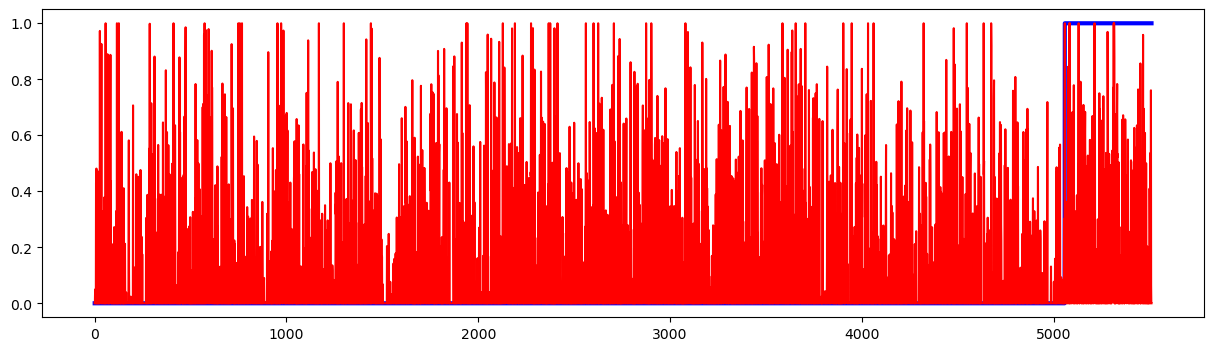

In [28]:
plt.figure(figsize=(15, 4))
plt.plot(TEST_target[:], 'b-', lw=3.0)
plt.plot(Y_pred[:], 'r-')
#plt.plot(Y_pred>0.5)

In [29]:
learning_rate

array([4.90729322e-04, 4.94771022e-04, 4.97671487e-04, 4.99417192e-04,
       5.00000000e-04, 4.99417192e-04, 4.97671487e-04, 4.94771022e-04,
       4.90729322e-04, 4.85565231e-04, 4.79302825e-04, 4.71971305e-04,
       4.63604851e-04, 4.54242473e-04, 4.43927823e-04, 4.32708991e-04,
       4.20638286e-04, 4.07771986e-04, 3.94170081e-04, 3.79895988e-04,
       3.65016259e-04, 3.49600272e-04, 3.33719903e-04, 3.17449193e-04,
       3.00864003e-04, 2.84041662e-04, 2.67060603e-04, 2.50000000e-04,
       2.32939397e-04, 2.15958338e-04, 1.99135997e-04, 1.82550807e-04,
       1.66280097e-04, 1.50399728e-04, 1.34983741e-04, 1.20104012e-04,
       1.05829919e-04, 9.22280139e-05, 7.93617142e-05, 6.72910089e-05,
       5.60721773e-05, 4.57575267e-05, 3.63951489e-05, 2.80286954e-05,
       2.06971746e-05, 1.44347695e-05, 9.27067816e-06, 5.22897808e-06,
       2.32851349e-06, 5.82807702e-07])

In [30]:
# plt.pcolormesh(TEST_input[3154, ..., 2], cmap=plt.cm.nipy_spectral_r)
# plt.colorbar()

In [31]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [32]:
# ========== Training loop ========== #
L_storm = len(filename_neg_train)
L_aug = len(filename_pos_train)

for i in range(epochs):
    
    #model.compile(loss=keras.losses.mean_absolute_error, optimizer=keras.optimizers.Adam(lr=learning_rate[i]))
    
    backend.set_value(model.optimizer.learning_rate, learning_rate[i])
    
    shuffle(filename_neg_train)
    shuffle(filename_pos_train)
    
    #print('epoch = {}'.format(i))
    start_time = time.time()
    
    # loop of batch
    for j in range(L_train):
        
        #N_aug = int(np.random.uniform(2, 7))
        #N_aug = int(np.random.uniform(8, 14))
        #N_aug = int(np.random.uniform(10, 25))
        N_aug = int(np.random.uniform(35, 70))
        
        N_storm = batch_size - N_aug
        
        ind_storm = du.shuffle_ind(L_storm)
        ind_aug = du.shuffle_ind(L_aug)
        
        file_pick_storm = []
        for ind_temp in ind_storm[:N_storm]:
            file_pick_storm.append(filename_neg_train[ind_temp])

        file_pick_aug = []
        for ind_temp in ind_aug[:N_aug]:
            file_pick_aug.append(filename_pos_train[ind_temp])
        
        file_pick = file_pick_storm + file_pick_aug
        
        if len(file_pick) != batch_size:
            sregwet
        
        for k in range(batch_size):

            data = np.load(file_pick[k])
            
            for l, c in enumerate(ind_pick_from_batch):
            
                X_batch_64[k, ..., l] = data[..., c]
            
            if 'pos' in file_pick[k]:
                Y_batch[k, :] = np.random.uniform(0.9, 0.99)
            elif 'neg_neg_neg' in file_pick[k]:
                Y_batch[k, :] = np.random.uniform(0.01, 0.05)
            else:
                werhgaer
                
        #Y_batch_cate = tf.keras.utils.to_categorical(Y_batch)
        
        # # add noise within sparse inputs
        # for v in flag_sparse:
        #     X_batch[..., v] += np.random.uniform(0, 0.01, size=(batch_size, 128, 128))

        # shuffle indices
        ind_ = du.shuffle_ind(batch_size)
        X_batch_64 = X_batch_64[ind_, ...]
        Y_batch = Y_batch[ind_, :]
        
        # train on batch
        model.train_on_batch(X_batch_64, Y_batch);
    
    # epoch end operations
    Y_pred = model.predict([TEST_input_64])
    Y_pred[Y_pred<0] = 0
    Y_pred[Y_pred>1] = 1
    record_temp = verif_metric(TEST_target, Y_pred)
    
    # if i % 10 == 0:
    #     model.save(model_path_backup)
    
    if (record - record_temp > min_del) and (np.max(Y_pred) > 0.6):
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        #print('tol: {}'.format(tol))
        # save
        print('save to: {}'.format(model_path))
        model.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        tol += 1
        #print('tol: {}'.format(tol))
        if tol >= max_tol:
            print('Early stopping')
            sys.exit();
        else:
            #print('Pass to the next epoch')
            continue;
    print("--- %s seconds ---" % (time.time() - start_time))

0.03628414973162287
Validation loss improved from 0.11010410095647927 to 0.03628414973162287
save to: /glade/work/ksha/NCAR/Keras_models/SK15_T_Lead2_pp12


2022-10-22 15:03:34.925772: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/SK15_T_Lead2_pp12/assets
--- 897.2711873054504 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.044054580104024646
Validation loss 0.044054580104024646 NOT improved
0.03907768549537837
Validation loss 0.03907768549537837 NOT improved
0.04095736849664694
Validation loss 0.04095736849664694 NOT improved
0.0420584381903505
Validation loss 0.0420584381903505 NOT improved
0.03926704418901596
Validation loss 0.03926704418901596 NOT improved
0.03888596320429373
Validation loss 0.03888596320429373 NOT improved
0.05209707851033262
Validation loss 0.05209707851033262 NOT improved
0.04268430991122061
Validation loss 0.04268430991122061 NOT improved



KeyboardInterrupt



In [115]:
j

1816

In [38]:
j

123844

In [ ]:
https://mesonet.agron.iastate.edu/pickup/wwa/

In [29]:
10 % 3

1